In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

file = "004349043/kplr004349043-2009259160929_llc.fits.flare"
filefake = "004349043/kplr004349043-2009259160929_llc.fits.fake"

df = pd.read_table(file, comment="#", delimiter=",", 
                   names=("t_start", "t_stop", "t_peak", "amplitude", "FWHM", "duration", "t_peak_aflare1", 
                          "t_FWHM_aflare1", "amplitude_aflare1", "flare_chisq", "KS_d_model", "KS_p_model", 
                          "KS_d_cont", "KS_p_cont", "Equiv_Dur", "ED68i", "ED90i"))

dffake = pd.read_table(filefake, comment="#", delimiter=",", 
                   names=("t_start", "t_stop", "t_peak", "amplitude", "FWHM", "duration", "t_peak_aflare1", 
                          "t_FWHM_aflare1", "amplitude_aflare1", "flare_chisq", "KS_d_model", "KS_p_model", 
                          "KS_d_cont", "KS_p_cont", "Equiv_Dur", "ED68i", "ED90i"))


(0.1, 1)

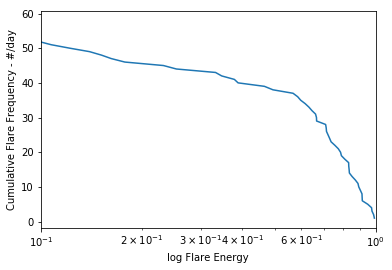

In [21]:
Nflare = df['amplitude'].size
energy = 10**np.random.random(Nflare)
sort = np.argsort(energy)
# energy[sort]
ffd_xEnergy = np.log10(energy[sort][::-1])
ffd_yFrequency = (np.arange(1, len(ffd_xEnergy)+1, 1))

#DO THIS
plt.plot(ffd_xEnergy, ffd_yFrequency)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('log Flare Energy')
plt.ylabel('Cumulative Flare Frequency - #/day')
plt.xlim(.1,1)

0     0.000846
1     0.008429
2     0.007241
3     0.002252
4     0.001916
5     0.003280
6     0.003465
7     0.009742
8     0.005020
9     0.007153
10    0.004380
11    0.002528
12    0.024526
13    0.004001
14    0.009893
15    0.002591
16    0.007989
17    0.005834
18    0.003270
19    0.010102
20    0.024649
21    0.002400
22    0.001468
23    0.003391
24    0.003891
25   -0.000686
26    0.000876
27    0.001270
28    0.003534
29    0.002459
30    0.003213
31    0.011095
32    0.003989
33    0.002049
34    0.001960
35    0.009645
36    0.001641
37    0.003095
38    0.002453
39    0.004146
40    0.004437
41    0.002472
42    0.007034
43    0.007104
44    0.003865
45    0.003524
46    0.021694
47    0.004003
48    0.003115
49    0.003562
50    0.004302
51    0.002385
52    0.002886
53    0.004501
54    0.005268
55    0.006728
56    0.001643
57    0.028650
Name: amplitude, dtype: float64
[0.024526232210800001, 0.02464894913, 0.0216943806404, 0.028650384764499999]


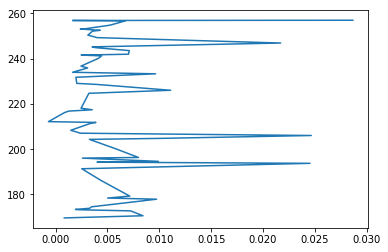

In [47]:
#11/7/2017
entryNum= df['amplitude'].size
ampSum = 0
flareArray=[]
for x in range (entryNum):
    ampSum = ampSum + (df['amplitude'][x])

#averageE = (sum/entryNum)
averageE = .015

for x in range (entryNum):
    if (df['amplitude'][x]) > averageE:
        flareArray.append(df['amplitude'][x])
print(df['amplitude'])
print(flareArray)
#plt.plot(df['amplitude'], np.cumsum())


In [16]:
#some misc examples

#y = np.arange(50,100,1) ** 2
#plt.plot(y, np.cumsum(y))

x = np.arange(50, 100, 1)
print(x[::-1]) # how to quickly reverse an array, very pythonic

#plt.plot(np.cumsum(x)/sum(x), label='x')
#plt.plot(np.cumsum(y)/sum(y), label='y')
#plt.legend()

# a reverse cumulative distribution
#plt.plot(x[::-1], np.cumsum(x[::-1]) / sum(x))

#plt.plot(df['t_start'], df['amplitude'])

# event = np.arange(0, len(x), 1)
# print(event)
# plt.plot(x[::-1], event)
# plt.plot(x[::-1], np.cumsum(event), '-o' )
# plt.yscale('log')
# plt.xscale('log')


[99 98 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77 76 75
 74 73 72 71 70 69 68 67 66 65 64 63 62 61 60 59 58 57 56 55 54 53 52 51 50]


In [ ]:
#questions:
#how to identify a flare
#is amplitude in proper units, conversion?
#Iron out a broad order of operations
#